In [1]:
import numpy as np
# import pandas as pd
import xarray as xr
# import zarr
# import xesmf as xe
import cartopy.crs as ccrs


In [2]:
# Grab some data 
!wget 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12/.forecast/.pr/X/230/300/RANGEEDGES/Y/24/50/RANGEEDGES/S/(1%20Dec%202020)/RANGEEDGES/%5BS%5Daverage/M/0/5/RANGEEDGES/L/0.5/7.5/RANGEEDGES/data.nc'


--2021-01-07 19:41:42--  http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12/.forecast/.pr/X/230/300/RANGEEDGES/Y/24/50/RANGEEDGES/S/(1%20Dec%202020)/RANGEEDGES/%5BS%5Daverage/M/0/5/RANGEEDGES/L/0.5/7.5/RANGEEDGES/data.nc
Resolving iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)... 129.236.110.35
Connecting to iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)|129.236.110.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737788 (720K) [application/x-netcdf]
Saving to: ‘data.nc’

data.nc             100%[===================>] 720.50K  1.18MB/s    in 0.6s    

2021-01-07 19:42:09 (1.18 MB/s) - ‘data.nc’ saved [737788/737788]



In [5]:
# Load some data
data = xr.open_dataset('data.nc')
    

In [15]:
import cmocean
cmocean.cm.cmapnames


['thermal',
 'haline',
 'solar',
 'ice',
 'gray',
 'oxy',
 'deep',
 'dense',
 'algae',
 'matter',
 'turbid',
 'speed',
 'amp',
 'tempo',
 'rain',
 'phase',
 'topo',
 'balance',
 'delta',
 'curl',
 'diff',
 'tarn']

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


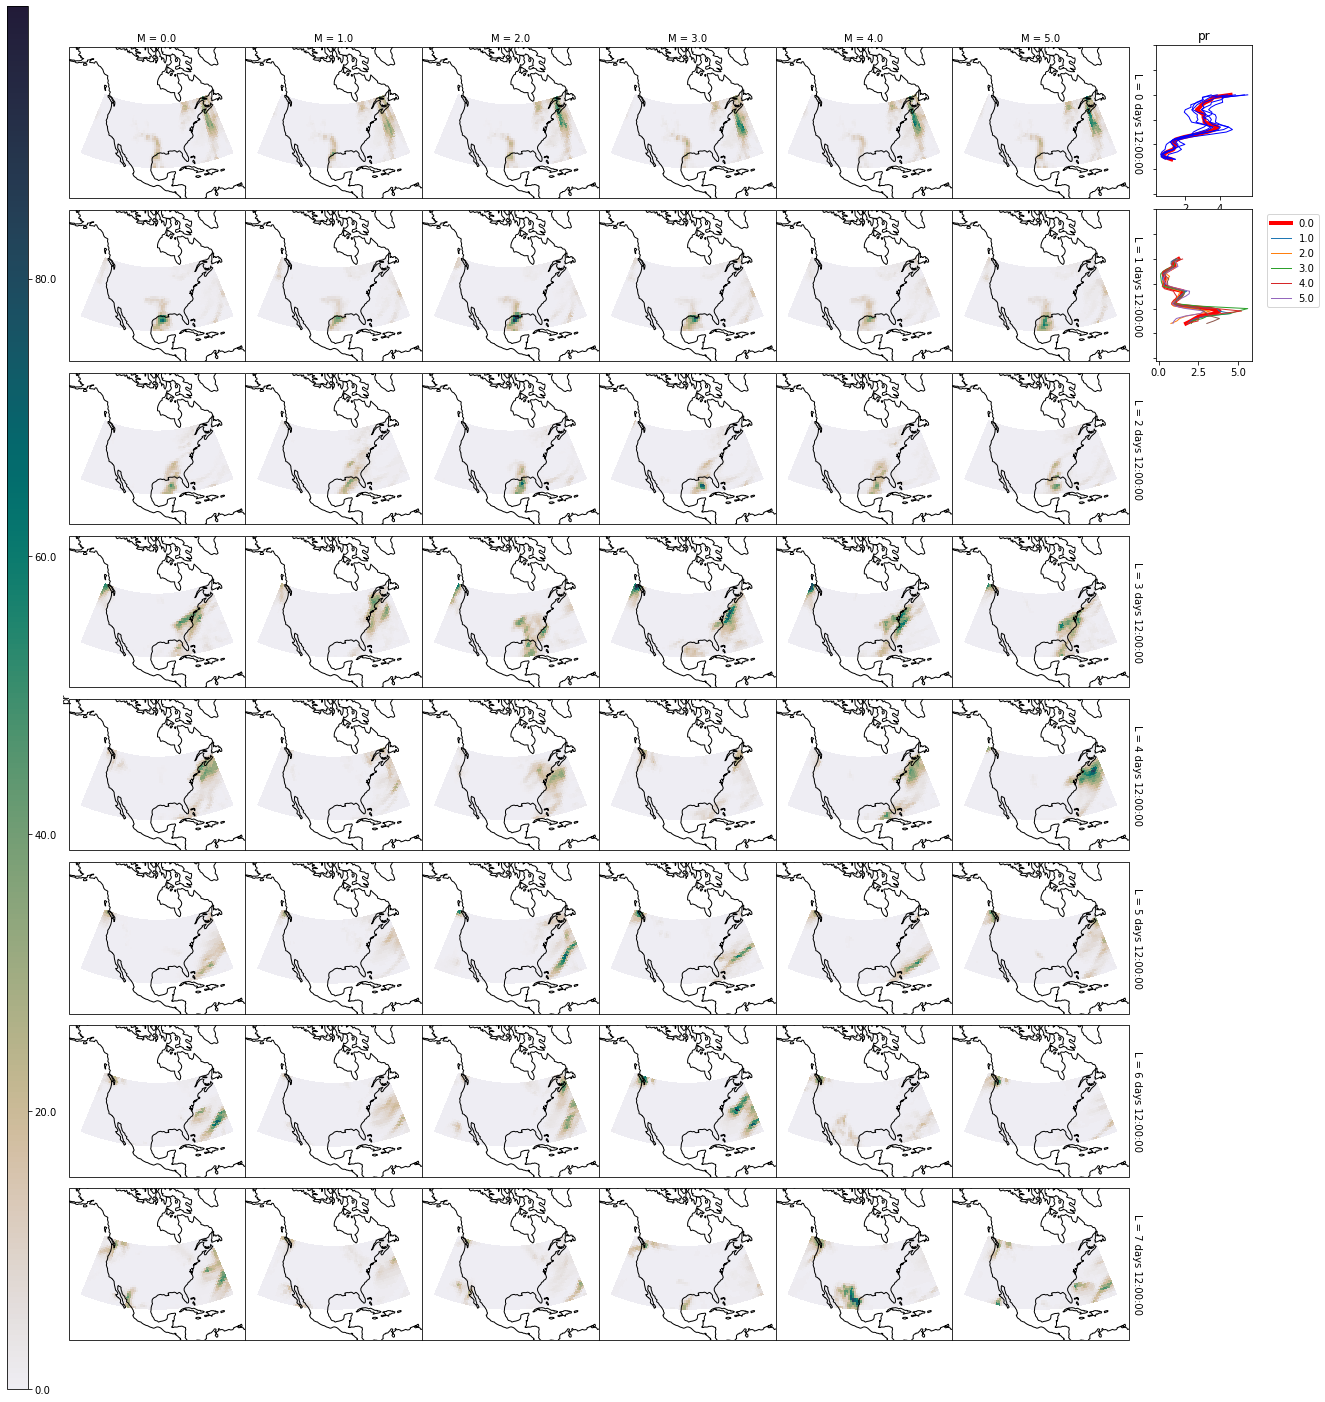

In [58]:
import matplotlib.pyplot as plt
cmap = cmocean.cm.rain

# this will set the extent of the map
ext = [230-360, 300-360, 9, 70]
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)


# multiply pr to have mm/day units and not super small numbers
p = (data.pr*86400).plot(transform=ccrs.PlateCarree(),  # the data's projection - this is almost always PlateCaree... 
                 col='M', # dimension used for the column
                 row='L',  # dimension used for the row of the plot
#              aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize - i don't think it's useful for facetgrid plots
                 subplot_kws={'projection': map_proj, }, # since you are plotting all those subplots together, 
                                                         # you need to tell which projection to use in transform kwarg for the subplots
                 cmap=cmap,# whatever cmap
                add_colorbar=False, # do not create the colorbar now, you will create it after   
                                )  # the plot's projection

# Everything is stored now in "p" you can explore it if you want.

# We have to set the map's options on all axes, which are within "p"
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(ext)

#I try to compact the figure as much as possible, it will never be 0 the space around figures
#because of the projections, but it helps.
plt.subplots_adjust(wspace=0, hspace=0)

# HERE I create a new ax where then I put the colorbar
# notice how i call the figure stored in "p" and then I add an axes to it
# the numbers are left bottom width height, so you have to play with it, they are relative to the whole figure. it can take a second..
cax = p.fig.add_axes([0.08, 0.1, 0.015, 0.8])
# add the colorbar to the figure "p" and i tell them which axes to use, cax.
p.add_colorbar(cax=cax, format='%.1f')

# Then if I want to add other plots (i.e. meridional means) you can just use the p.fig.add_axes trick again.
# it took me more than one iteration to match the plots, I think there should be a way to extract the axis location
# of the plots i want to match my plot with, but i couldn't figure it out. 
ax1 = p.fig.add_axes([0.92, 0.79, 0.07, 0.0875])
# so let's do an average along the columns (over M) - mind I don't mask for ocean, but just to give an idea.
# I then avearage along lon, but I have to select one L at the time, because I am not using the "col" or "row" option
# I also tell xarray which dimension is the y axis
(data.pr*86400).mean('M').mean(dim='X').isel(L=0).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=4, color='r')
(data.pr*86400).mean(dim='X').isel(L=0).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=1, color='b')
#setting the extent of my plot, so that latitudes match with the map.
# I clean up the extra plot 
ax1.set_ylim(9, 70)
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('pr')


# add another one and add a legend to that
ax1 = p.fig.add_axes([0.92, 0.695, 0.07, 0.0875])
# so let's do an average along the columns (over M) - mind I don't mask for ocean, but just to give an idea.
# I then avearage along lon, but I have to select one L at the time, because I am not using the "col" or "row" option
# I also tell xarray which dimension is the y axis
(data.pr*86400).mean('M').mean(dim='X').isel(L=1).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=4, color='r')
pp = (data.pr*86400).mean(dim='X').isel(L=1).drop('L').plot.line(y='Y', ax = ax1, add_legend=False, lw=1)
#setting the extent of my plot, so that latitudes match with the map.
# I clean up the extra plot 
ax1.set_ylim(9, 70)
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.legend(data.M.values , bbox_to_anchor = (1.1, 1))

p.fig.set_rasterized(True)
plt.savefig('aaa.png', bbox_inches='tight')
